In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager as font_manager

# funciones desarrolladas
from functions.cargar_data import *
from functions.graficas import *

In [2]:
variables = ['DPTO', 'LOC','PERMI07', 'PERMI07_1', 'PERMI07_2', 'PERMI07_3', 'PERMI07_4']

In [3]:
censo = cargar_censo_vars(variables)

In [4]:
censo.head()

,DPTO,LOC,PERMI07,PERMI07_1,PERMI07_2,PERMI07_3,PERMI07_4
0,1,20,0,NaN,NaN,NaN,0
1,1,20,0,NaN,NaN,NaN,0
2,1,20,0,NaN,NaN,NaN,0
3,1,20,0,NaN,NaN,NaN,0
4,1,20,0,NaN,NaN,NaN,0


In [5]:
def conteo_migrantes(df):
    "Conteo de migrantes interno por departamento"
    lista_vars = ['total', 'cat_a', 'cat_b', 'cat_c']
    df[lista_vars[0]] = 1
    [df.insert(len(df.columns), lista_vars[i], 0) for i in range(1,4)]
    # destino Mvdeo.
    df.loc[(df.PERMI07 == 3) & (df.DPTO==1), lista_vars[1]] = 1
    # destino interior
    df.loc[(df.PERMI07 == 3) & (df.PERMI07_2== 1), lista_vars[2]] = 1
    # entre interior
    df.loc[(df.PERMI07 == 3) & (df.PERMI07_2!=1) & (df.DPTO!=1) & (df.PERMI07_2.isnull()==False), lista_vars[3]] = 1

    # agrupa
    df_group = df.groupby('DPTO').agg(
                {   'total': sum,
                     lista_vars[1]: sum,
                     lista_vars[2]: sum,
                     lista_vars[3]: sum
                })

    df_group['total_mig'] = df_group[lista_vars[1]] + df_group[lista_vars[2]] + df_group[lista_vars[3]]
    
    return df_group

In [6]:
migrantes = conteo_migrantes(censo)
migrantes

,total,cat_a,cat_b,cat_c,total_mig
DPTO,,,,,
1,1318755,42444,0,0,42444
2,73377,0,914,896,1810
3,520173,0,33127,8286,41413
4,84698,0,1387,1614,3001
5,123203,0,2100,3362,5462
6,57084,0,982,1589,2571
7,25050,0,378,933,1311
8,67047,0,1026,2257,3283
9,58815,0,825,1760,2585


In [7]:
# Exporta CSV
# migrantes.to_csv('tablas/migrantes_por_depto.csv')

In [8]:
# exporta CSVT
campos = 'Integer','Integer','Integer','Integer','Integer','Integer'

def export_csvt(lista, filename):
    "Exporta lista a archivo csvt para usars con QGIS"
    campos_str = ','.join([str(elem) for elem in campos])
    with open(filename, 'w') as f:
        f.write(str(campos_str) + "\n")

In [9]:
# export_csvt(campos, 'tablas/migrantes_por_depto.csvt')

In [10]:
censo.groupby(['PERMI07_2', 'PERMI07_3']).DPTO.count().reset_index()

,PERMI07_2,PERMI07_3,DPTO
0,1.0,20.0,57982
1,1.0,621.0,125
2,1.0,622.0,133
3,1.0,721.0,173
4,1.0,900.0,237
...,...,...,...
890,19.0,949.0,2
891,19.0,951.0,5
892,19.0,953.0,1
893,19.0,960.0,4


In [11]:
def conteo_migrantes_por_loc(df):
    "Conteo por localidad de migrantes internos con origen en Mvdeo."
    df_filtered = df.loc[(df.PERMI07 == 3) & (df.PERMI07_2== 1)].copy()
    df_filtered['CODLOC'] = df_filtered.DPTO.astype(str) + pad(df_filtered, 'LOC', 3)
    df_grouped = df_filtered.groupby(['CODLOC']).DPTO.count().reset_index()
    df_grouped.rename({'CODLOC':'loc_destino', 'DPTO':'personas'}, inplace=True, axis=1)
    
    return df_grouped.sort_values('personas', ascending=False)

In [12]:
mig_loc = conteo_migrantes_por_loc(censo)

In [13]:
mig_loc.head()

,loc_destino,personas
290,3828,2699
328,3953,2660
284,3732,2600
241,3221,2110
146,16521,2014


In [17]:
# exporta
# mig_loc.to_csv('tablas/migrantes_no_mvo_por_loc.csv', index=False)
# campos = 'Integer','Integer'
# export_csvt(campos, 'tablas/migrantes_no_mvo_por_loc.csvt')

In [31]:
locs = pd.read_csv('tablas/localidades_censales_2011.csv',
                  dtype= {'departamento': str,'localidad': str, 'codloc': str,},
                  usecols=['departamento','localidad','codloc'])
locs.head()

,departamento,localidad,codloc
0,MONTEVIDEO,MONTEVIDEO,1020
1,ARTIGAS,ARTIGAS,2220
2,ARTIGAS,BELLA UNION,2521
3,ARTIGAS,TOMAS GOMENSORO,2522
4,ARTIGAS,BALTASAR BRUM,2621


In [32]:
merge_loc = mig_loc.merge(locs, left_on='loc_destino', right_on='codloc')
merge_loc.head(10)

,loc_destino,personas,departamento,localidad,codloc
0,3828,2699,CANELONES,EL PINAR,3828
1,3953,2660,CANELONES,LOMAS DE SOLYMAR,3953
2,3732,2600,CANELONES,SOLYMAR,3732
3,3221,2110,CANELONES,LAS PIEDRAS,3221
4,16521,2014,SAN JOSE,DELTA DEL TIGRE Y VILLAS,16521
5,3521,1629,CANELONES,BARROS BLANCOS,3521
6,3525,1501,CANELONES,PASO CARRASCO,3525
7,15120,1322,SALTO,SALTO,15120
8,3727,1188,CANELONES,PARQUE CARRASCO,3727
9,13220,1185,RIVERA,RIVERA,13220


In [38]:
# porcentaje de personas migrantes internas corresppondientes a las 7
# localidades que más reciben migrantes
merge_loc.head(7).personas.sum() / merge_loc.personas.sum() *100

27.15249518098094

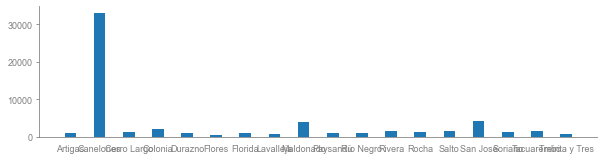

In [19]:
# Gráfica
size = 9
font = {'fontname': 'Arial', 'fontsize': size}

mig_ori_mvo = migrantes.cat_b.values.tolist()[1:]
labels = cargar_nombres()[1:]

fig, ax = plt.subplots(figsize=[10, 2.4])

# n de barras
ind=np.arange(len(mig_ori_mvo))

# ancho de las barras
bars_width=0.40
    # límite en eje Y
# plt.ylim(0, ylim)
    # controla el intervalo de etiquetas en los ticks del eje Y
#     plt.yticks(np.arange(0, ylim + 0.1, sep))
    # plotea
plt.bar(ind, mig_ori_mvo, width=bars_width, label=labels)


format_spines('grey', ax)

format_ticks(labels, 'grey', ind, font)

#     # línea de dato país
#     plt.axhline(dato_censo, color='k')
#     # agrega texto sobre el valor para todo el país
#     ax.text(-0.2, dato_censo * 1.05, 'Valor para el país', **font)
#     # exporta
#     save_chart(filename + '.pdf')
    # muestra
plt.show()